## Robot Perception Homework

Minh Nguyen

Lecture date 14.04.2016

---

### Questions
1. **Is the normalization process applied to the homogeneous coordinates or just the (x, y) values?**
    - When moving the coordinates to the origin, for the homogeneous coordinates, the 1. will disappear anyway. 
    Therefore, it only makes sense to apply the normalization to (x, y) only, then transform the result to homogeneous
    coordinates.
2. **Why is H the eigenvector corresponding to the smallest positive singular value of matrix A?**
    - I actually don't know
---

### Homework

1. **Reading - Chapter 4 MVG**

    <img src="./RP_NGUYENMINH_Homework_20160414.png">  

2. **Implement Algor 4.2**
    (normalized DLT)


In [1]:
import scipy as sp
import numpy as np
from scipy.ndimage import imread
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

%matplotlib inline

In [2]:
def dlt_normalized(x, x_tick):
    '''
    Perform normalized DLT algorithm

    @param: homogeneous coordinates of similar points in 2 images, in 2D
            numpy array format
    @return: transform matrix
    '''
    # Normalize x and x_tick
    (x_similar_transform, x_norm) = normalize(x)
    (x_tick_similar_transform, x_tick_norm) = normalize(x_tick)
    # DLT algorithm
    H_norm = dlt(x_norm, x_tick_norm)
    # Denormalize H_norm
    H = np.dot(np.dot(np.linalg.inv(x_tick_similar_transform), H_norm), x_similar_transform)
    return H

def dlt(x, x_tick):
    '''
    Perform DLT algorithm
    '''
    # Dimension check
    if x.shape != x_tick.shape:
        print("Input arrays must have same dimensions")
        return None

    # Construct matrix A in equation A.H = 0
    A = None
    zeros = np.zeros(3)
    for i in range(len(x)):
        # First row of A_i [0  -w'x  y'x]
        A_i_0 = zeros
        A_i_0 = np.append(A_i_0, - x_tick[i][2]*x[i])
        A_i_0 = np.append(A_i_0,   x_tick[i][1]*x[i])
        A_i_0 = A_i_0.reshape(1, len(A_i_0))
        # Second row of A_i [w'x  0  -x'x]
        A_i_1 = x_tick[i][2]*x[i]
        A_i_1 = np.append(A_i_1,   zeros)
        A_i_1 = np.append(A_i_1, - x_tick[i][0]*x[i])
        A_i_1 = A_i_1.reshape(1, len(A_i_1))
        # Append to A
        if A is None:
            A = A_i_0
        else:
            A = np.append(A, A_i_0, axis=0)
        A = np.append(A, A_i_1, axis=0)

    # SVD decomposition, H is the eigenvector corresponding to the
    # smallest singular value
    u, s, v = np.linalg.svd(A, full_matrices=False)
    H = v[np.argmin(s)].reshape(3, 3)
    # Divide by H[2][2] for correct scaling? Not sure why this worked
    H = H/H[2][2]
    return H

def normalize(x):
    # Calculate centroid of points and translate points to origin
    centroid = np.mean(x, axis=0)
    x_normalized = x - centroid
    # Calculate the average distance to origin
    scale_factor = np.mean(np.sqrt(np.sum(x_normalized**2, axis=1)))
    # Scale factor to achieve average distance sqrt(2)
    scale_factor = np.sqrt(2) / scale_factor
    x_normalized = x_normalized * scale_factor
    x_normalized = make_homog(x_normalized)
    # Similarity transform matrix, no rotation, in the form:
    # | s 0 t_x |
    # | 0 s t_y |
    # | 0 0   1 |
    similarity_transform = np.array([[scale_factor, 0, - scale_factor * centroid[0]],
                                     [0, scale_factor, - scale_factor * centroid[1]],
                                     [0, 0, 1]])

    return (similarity_transform, x_normalized)

def make_homog(x):
    return np.append(x, np.ones((len(x), 1)), axis=1)

In [3]:
img1 = imread("boat/img1+points.png")
img2 = imread("boat/img2+points.png")
with open("boat/homography.txt") as f:
    lines = f.readlines()

# Get the text coordinates
lines[0] = lines[0][lines[0].find('[') + 1:lines[0].find(']')]
lines[1] = lines[1][lines[1].find('[') + 1:lines[1].find(']')]

# Split coordinate pairs
lines[0] = lines[0].split(';')
lines[1] = lines[1].split(';')

# Map coordinates to 2D int arrays
x = []
x_tick = []
for i in range(len(lines[0])):
    x.append(list(map(int, lines[0][i].split(','))))
    x_tick.append(list(map(int, lines[1][i].split(','))))

x = np.array(x)
x_tick = np.array(x_tick)

In [4]:
# Calculate transformation matrix
H = dlt_normalized(x, x_tick)

print(H)

x_homog = make_homog(x)
x_tick_homog = make_homog(x_tick)
x_tick_from_x = np.dot(H, np.transpose(x_homog[0])).reshape(1, 3)
for x_row in x_homog[1:]:
    x_tick_from_x = np.append(x_tick_from_x, np.dot(H, np.transpose(x_row)).reshape(1, 3), axis=0)


print("\nEuclidean distance between x values of reconstructed x_tick_homog and original:")
print(euclidean(x_tick_from_x[:, 0], x_tick_homog[:, 0]))
print("\nEuclidean distance between y values of reconstructed x_tick_homog and original:")
print(euclidean(x_tick_from_x[:, 1], x_tick_homog[:, 1]))


[[  8.62747991e-01   2.29010735e-01   3.41961201e+00]
 [ -2.11027610e-01   8.66498572e-01   1.27727513e+02]
 [  1.09223840e-05   2.99622112e-05   9.85489785e-01]]

Euclidean distance between x values of reconstructed x_tick_homog and original:
6.53962148485

Euclidean distance between y values of reconstructed x_tick_homog and original:
4.95596471449


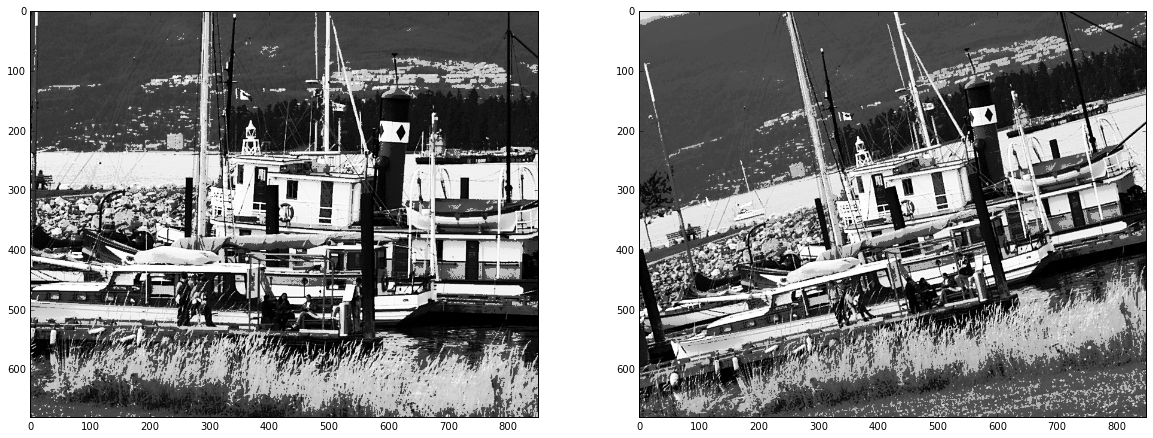

In [5]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(img1, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img2, cmap='gray')

In [6]:
x_range, y_range = img2.shape
img_reconstruct = np.zeros((x_range, y_range))
for x in range(x_range):
    for y in range(y_range):
        x_tick, y_tick, w = np.dot(H, np.transpose([x, y, 1.]))
        x_tick = int(np.round(x_tick))
        y_tick = int(np.round(y_tick))
        if x_tick < x_range and y_tick < y_range:
            img_reconstruct[x_tick, y_tick] = img2[x, y]

The following image is transformed using the calculated matrix. The color value of each pixel in img2 is copied to the reconstructed image. The coordinate of the pixel is the reconstructed image is found from the dot product of the corresponding pixel coordinates in img2 and H:

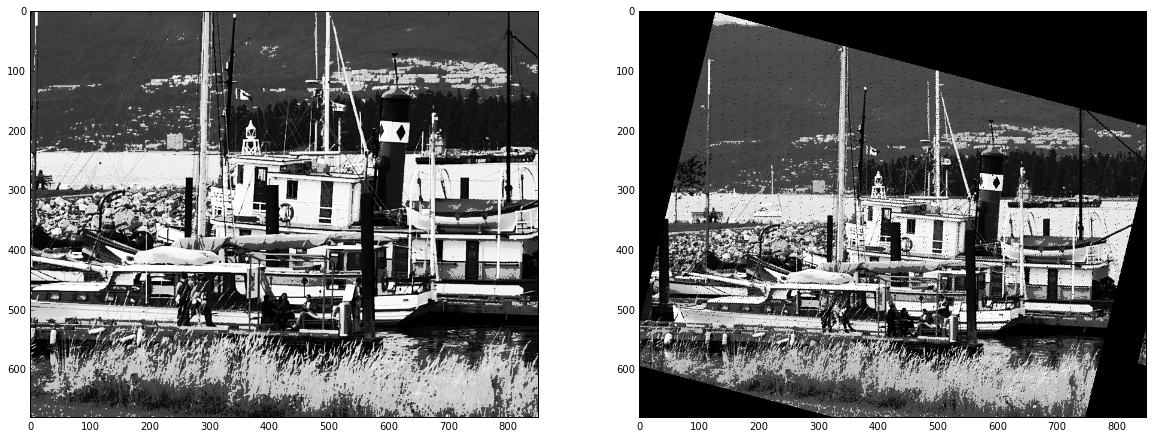

In [7]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(img1, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img_reconstruct, cmap='gray')

I couldn't find any built-in functin to test the method against.